# Regression benchmark 

In [1]:
import os
import re
import jax
import optax
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt
from time import time
from rebayes.sgd_filter import replay_sgd as rsgd

In [2]:
import flax.linen as nn

In [3]:
def plot_bounds(data, ax, color, label, rolling=100):
    n_obs = len(data)
    xrange = np.arange(n_obs)
    data.mean(axis=1).rolling(rolling).mean().plot(ax=ax, label=label, color=color)
    
    sims = data.rolling(rolling).mean().values
    mean_sim = sims.mean(axis=1)
    std_sim = sims.std(axis=1)
    
    lbound = mean_sim - 1 * std_sim
    ubound = mean_sim + 1 * std_sim
    
    ax.fill_between(xrange, lbound, ubound, alpha=0.2, color=color)

In [4]:
from rebayes.utils.utils import tree_to_cpu, get_subtree

In [5]:
%config InlineBackend.figure_format = "retina"

In [6]:
def load_output(filename, path):
    filename = os.path.join(path, filename)
    with open(filename, "rb") as f:
        res = pickle.load(f) 
    return res

In [7]:
def tree_shape(tree):
    return jax.tree_map(jnp.shape, )

In [22]:
base_path = "./output/rotating-mnist/"

In [23]:
dataset_name = "rotating-mnist-2-mlp"

filenames = os.listdir(base_path)
# filenames = [file for file in filenames if (dataset_name in file)]

In [24]:
dataset_name = "rotating-mnist-2-mlp-"
agents = [filename.replace(dataset_name, "").rstrip(".pkl") for filename in filenames]

In [25]:
agents_output = {}
agents_res = {}
for i, (agent_name, filename) in enumerate(zip(agents, filenames)):
    res = load_output(filename, base_path)
    agent_name = f"{agent_name}"
    agents_output[agent_name] = res["output"]
    agents_res[agent_name] = res

In [26]:
colors = plt.cm.tab10(np.linspace(0, 1, len(agents) + 1))
colors = plt.cm.tab10(np.arange(len(agents) + 1))
colors = {
    name_agent: color
    for name_agent, color
    in zip(agents + ["sgd-rb"], colors)
}

In [27]:
data = get_subtree(agents_output, "test")
data = tree_to_cpu(data)
data = pd.DataFrame(data)
data.tail()

,rank10_lofi,rank10_lofi_orth,rank10_sgd-rb,rank1_lofi,rank1_lofi_orth,rank1_sgd-rb,rank20_lofi,rank20_lofi_orth,rank20_sgd-rb,rank30_sgd-rb,rotating-mnist-2-mlp_lofi,rotating-mnist-2-mlp_lofi_orth
4995,51.287865,17.651781,14.608284,27.980509,17.682465,14.900990,30.130501,17.046368,14.718262,14.858821,14.319849,35.805260
4996,51.554588,17.490057,14.863052,29.256239,17.271809,14.852650,30.292170,17.130653,14.910536,14.797904,14.314020,30.695301
4997,52.451157,18.557177,14.989017,29.388720,19.980553,15.065526,30.046740,20.051571,14.654101,14.766777,14.410007,40.873688
4998,51.281563,18.471918,14.945620,29.243696,19.247986,14.886106,28.525864,19.853533,14.755125,14.872256,14.655076,28.597885
4999,51.517990,18.307425,14.930132,28.471027,17.952135,14.818531,28.856741,18.216825,14.948064,14.862144,14.472292,29.140095


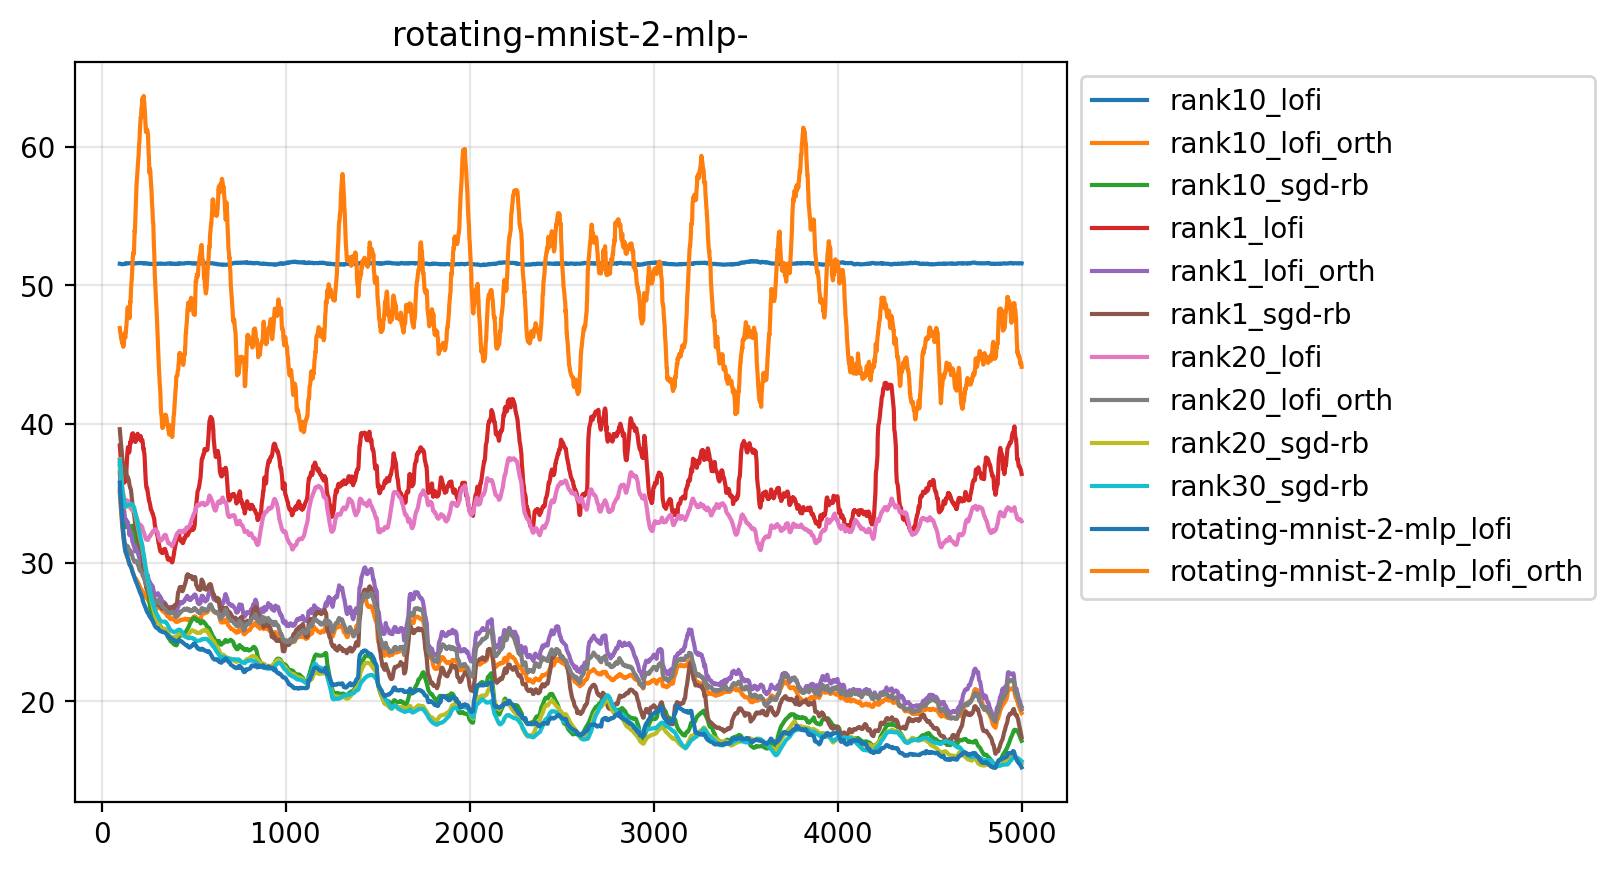

In [28]:
fig, ax = plt.subplots()

vmin, vmax = data.iloc[-1].min(), data.iloc[-1].max()
data.rolling(100).mean().plot(ax=ax)
ax.set_title(dataset_name)
# plt.ylim(vmin * 0.9, vmin * 2.3)
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1,1))

## Agent analysis

In [36]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

plt.rcParams["font.size"] = 14
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["lines.linewidth"] = 2

In [37]:
import regression_train as benchmark

In [38]:
from functools import partial
from regression_train import MLP
from jax.flatten_util import ravel_pytree
from rebayes.utils import uci_uncertainty_data

from rebayes.extended_kalman_filter import ekf
from rebayes.low_rank_filter import lofi, lrvga
from rebayes.sgd_filter import sgd

In [39]:
import hparam_tune_ekf as hp_ekf
import hparam_tune_lofi as hp_lofi

In [40]:
methods = list(agents_res.keys()) + ["sgd-rb"]

In [576]:
path = (
    "/home/gerardoduran/documents/external"
    "/DropoutUncertaintyExps/UCI_Datasets/"
    f"{dataset_name}/"
    "data"
)

In [577]:
train_folds, test_folds, coefs_all = uci_uncertainty_data.load_folds_data(path)
_, n_features = train_folds[0][0].shape

train_folds = jax.tree_map(jnp.nan_to_num, train_folds)
test_folds = jax.tree_map(jnp.nan_to_num, test_folds)



X_train, y_train = train_folds
X_test, y_test = test_folds

In [578]:
key = jax.random.PRNGKey(314)
model = MLP(1, activation=nn.relu)

params_init = model.init(key, jnp.ones((1, n_features)))
params_flat, reconstruct_fn = ravel_pytree(params_init)
apply_fn = partial(benchmark.apply_main, model=model, unflatten_fn=reconstruct_fn)

In [579]:
dim_rank = 50
params_lofi = lofi.LoFiParams(
    memory_size=dim_rank,
    sv_threshold=0,
    steady_state=True,
)

method = "lofi_orth"
method = "vdekf"
hparams = agents_res[method]["hparams"]["params"]

In [580]:
agents_res["lofi"]["hparams"]["params"]

{'dynamics_weights': 0.9012872242211605,
 'log_emission_cov': -5.753669060943524,
 'log_init_cov': -3.818435047614428}

In [581]:
def benchmark_lofi(X_train, y_train, X_test, y_test, coefs, method, hparams):
    train = (X_train, y_train)
    test = (X_test, y_test)
    eval_callback = partial(benchmark.eval_callback_main,
                            ymean=coefs["ymean"], ystd=coefs["ystd"])
    
    bel, output = benchmark.eval_lofi_agent(
        train, test, hparams, params_flat, params_lofi, apply_fn, method, eval_callback
    )
    return output


def benchmark_ekf(X_train, y_train, X_test, y_test, coefs, method, hparams, **kwargs):
    train = (X_train, y_train)
    test = (X_test, y_test)
    eval_callback = partial(benchmark.eval_callback_main,
                            ymean=coefs["ymean"], ystd=coefs["ystd"])
    
    bel, output = benchmark.eval_ekf_agent(
        train, test, hparams, params_flat, apply_fn, method, eval_callback
    )
    return output


def benchmark_lrvga(X_train, y_train, X_test, y_test, coefs, method, hparams, **kwargs):
    train = (X_train, y_train)
    test = (X_test, y_test)
    
    eval_callback = partial(benchmark.eval_callback_main,
                            ymean=coefs["ymean"], ystd=coefs["ystd"])
    
    bel, output = benchmark.eval_lrvga(
        train, test, hparams, apply_fn, eval_callback, **kwargs
    )
    
    return output



def benchmark_replay_sgd(X_train, y_train, X_test, y_test, coefs, method, hparams, **kwargs):
    train = (X_train, y_train)
    test = (X_test, y_test)

    eval_callback = partial(benchmark.eval_callback_main,
                            ymean=coefs["ymean"], ystd=coefs["ystd"])
    
    bel, output = benchmark.eval_sgd_agent(
        train, test, apply_fn_sgd, eval_callback, **kwargs
    )
    
    return output


def eval_agent_multiple(train, test, coefs, benchmark_fn, method, hparams, n_cores=5, **kwargs):
    X_train, y_train = train
    X_test, y_test = test
    train_shape = X_train.shape[1:]
    test_shape = X_test.shape[1:]
    
    X_train = X_train.reshape(-1, n_cores, *train_shape)
    y_train = y_train.reshape(-1, n_cores, train_shape[0])
    
    X_test = X_test.reshape(-1, n_cores, *test_shape)
    y_test = y_test.reshape(-1, n_cores, test_shape[0])
    
    coefs = jax.tree_map(lambda x: x.reshape(-1, n_cores), coefs)
    
    benchmark_fn = partial(benchmark_fn, method=method, hparams=hparams, **kwargs)
    
    peval = jax.jit(benchmark_fn)
    peval = jax.vmap(benchmark_fn, in_axes=0)
    peval = jax.pmap(peval, in_axes=1)

    res = peval(X_train, y_train, X_test, y_test, coefs)
    
    res = jax.tree_map(lambda x: x.reshape(-1, *x.shape[2:]), res)
    return res

In [582]:
n_cores = 5

# Evaluate results

In [583]:
results = {}

## EKF

In [584]:
%%time
method = "fcekf"
time_init = time()
hparams = agents_res[method]["hparams"]["params"]
res = eval_agent_multiple(train_folds, test_folds, coefs_all, benchmark_ekf, method, hparams, n_cores)
jax.block_until_ready(res)
time_end = time()

res["running_time"] = time_end - time_init
results[method] = tree_to_cpu(res)

CPU times: user 2.07 s, sys: 133 ms, total: 2.21 s
Wall time: 1.61 s


In [585]:
%%time
time_init = time()

method = "fdekf"
hparams = agents_res[method]["hparams"]["params"]
res = eval_agent_multiple(train_folds, test_folds, coefs_all, benchmark_ekf, method, hparams, n_cores)
jax.block_until_ready(res)
jax.tree_map(jnp.shape, res)

time_end = time()

res["running_time"] = time_end - time_init
results[method] = tree_to_cpu(res)

CPU times: user 1.58 s, sys: 55.9 ms, total: 1.64 s
Wall time: 1.29 s


In [586]:
%%time
time_init = time()

method = "vdekf"
hparams = agents_res[method]["hparams"]["params"]
res = eval_agent_multiple(train_folds, test_folds, coefs_all, benchmark_ekf, method, hparams, n_cores)
jax.block_until_ready(res)
jax.tree_map(jnp.shape, res)

time_end = time()
res["running_time"] = time_end - time_init
results[method] = tree_to_cpu(res)

CPU times: user 1.94 s, sys: 115 ms, total: 2.06 s
Wall time: 1.6 s


## LoFi

In [587]:
%%time
time_init = time()

method = "lofi_orth"
hparams = agents_res[method]["hparams"]["params"]
res = eval_agent_multiple(train_folds, test_folds, coefs_all, benchmark_lofi, method, hparams, n_cores)
jax.block_until_ready(res)
jax.tree_map(jnp.shape, res)

time_end = time()

res["running_time"] = time_end - time_init
results[method] = tree_to_cpu(res)

CPU times: user 8.44 s, sys: 557 ms, total: 9 s
Wall time: 5.36 s


In [588]:
%%time
time_init = time()

method = "lofi"
hparams = agents_res[method]["hparams"]["params"]
res = eval_agent_multiple(train_folds, test_folds, coefs_all, benchmark_lofi, method, hparams, n_cores)
jax.block_until_ready(res)
jax.tree_map(jnp.shape, res)

time_end = time()

res["running_time"] = time_end - time_init
results[method] = tree_to_cpu(res)

CPU times: user 13.2 s, sys: 1.13 s, total: 14.3 s
Wall time: 8.81 s


## L-RVGA

In [589]:
fwd_link = partial(benchmark.fwd_link_main, model=model, reconstruct_fn=reconstruct_fn)
lrvga_kwargs = {
    "model": model,
    "fwd_link": fwd_link,
    "log_prob": partial(benchmark.log_prob_main, fwd_link=fwd_link),
    "dim_rank": 50,
    "n_outer": 6,
    "n_inner": 4,
    "key": key,
}

In [590]:
%%time
time_init = time()

method = "lrvga"
hparams = agents_res[method]["hparams"]["params"]
res = eval_agent_multiple(train_folds, test_folds, coefs_all, benchmark_lrvga, method, hparams, **lrvga_kwargs)
jax.block_until_ready(res)
jax.tree_map(jnp.shape, res)

time_end = time()

res["running_time"] = time_end - time_init
results[method] = tree_to_cpu(res)

CPU times: user 35.3 s, sys: 3.45 s, total: 38.7 s
Wall time: 1min 30s


## SGD—replay buffer

In [591]:
def apply_fn_sgd(params, x, model):
    return model.apply(params, x)

apply_fn_sgd = partial(apply_fn_sgd, model=model)

In [592]:
%%time
time_init = time()


method = "sgd-rb"
learning_rate = 1e-4
buffer_size = 50
n_inner = 10


state_init = rsgd.FifoTrainState.create(
    apply_fn=model.apply,
    params=params_init,
    tx=optax.adam(learning_rate),
    buffer_size=buffer_size,
    dim_features=n_features,
    dim_output=1,
)


agent = rsgd.FSGD(benchmark.lossfn_rmse_fifo, n_inner=n_inner)

sgd_kwargs = {
    "agent": agent,
    "bel_init": state_init,
}

hparams = None
res = eval_agent_multiple(
    train_folds, test_folds, coefs_all, benchmark_replay_sgd, method, hparams, **sgd_kwargs
)

time_end = time()

res["running_time"] = time_end - time_init
results[method] = tree_to_cpu(res)

CPU times: user 1.74 s, sys: 44.5 ms, total: 1.78 s
Wall time: 1.51 s


## Store result

In [593]:
pd.DataFrame(jax.tree_map(jnp.nanmean, results))

,fcekf,fdekf,lofi,lofi_orth,lrvga,sgd-rb,vdekf
osa-error,0.53000885,0.68037206,0.6969449,0.70093924,0.51620203,0.55885524,0.53168446
running_time,1.6070161,1.2860017,8.81059,5.3582144,90.17502,1.5049891,1.6004584
test,0.69374704,0.8198268,0.88819975,0.8755907,0.6646969,0.72717494,0.6836479


In [594]:
import pickle

path_cval = os.path.join("output", "cross-validation")
path_store = os.path.join(path_cval, f"{dataset_name}.pkl")

with open(path_store, "wb") as f:
    pickle.dump(results, f)

# Plots

In [595]:
test_collection = get_subtree(results, "test")
osa_collection =  get_subtree(results, "osa-error")

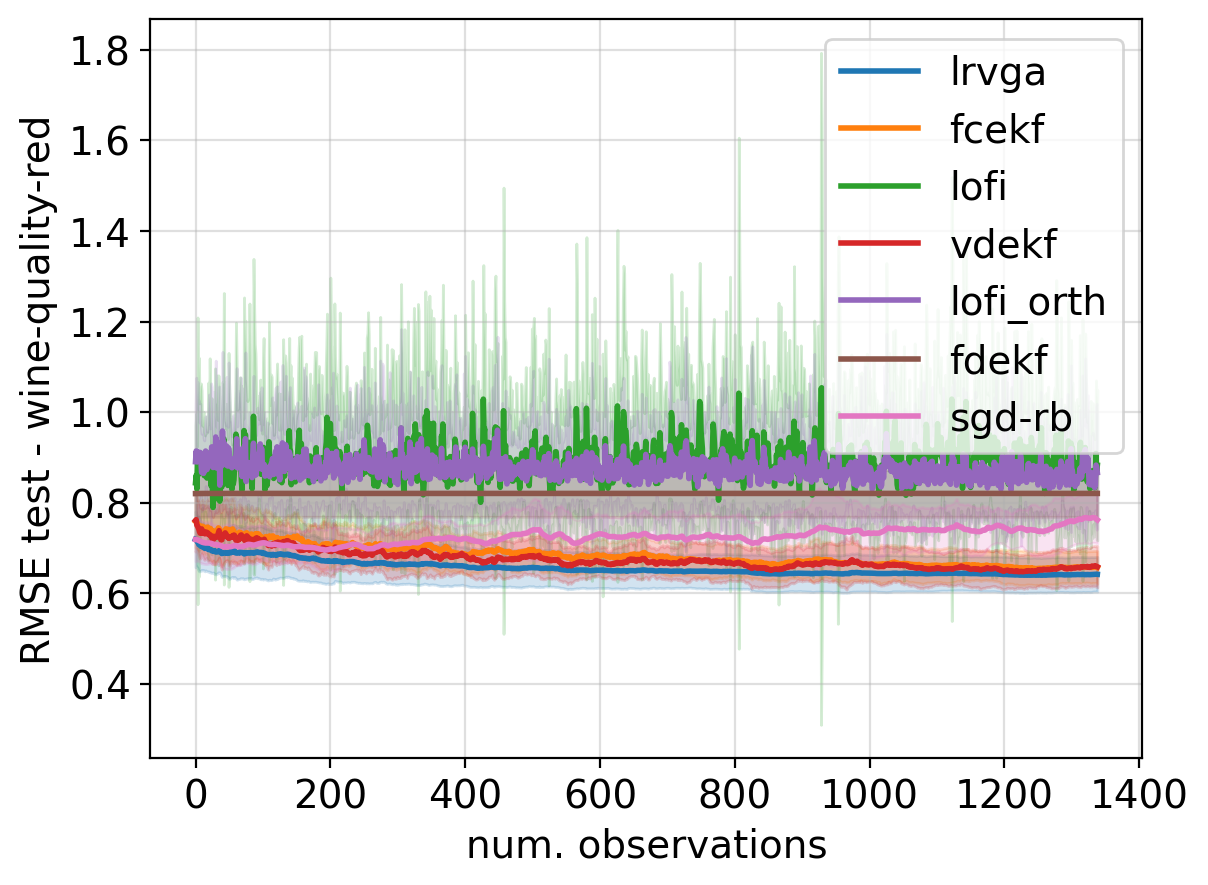

In [596]:
fig, ax = plt.subplots()
for method in methods:
    color = colors[method]
    label = f"{method}"
    test_res = pd.DataFrame(test_collection[method].T[100:])
    plot_bounds(test_res, ax, color, label, rolling=1)
plt.legend()
plt.ylabel(f"RMSE test - {dataset_name}")
plt.xlabel("num. observations")
plt.grid(alpha=0.4)
plt.savefig(f"output/images/{dataset_name}-test-set.pdf")

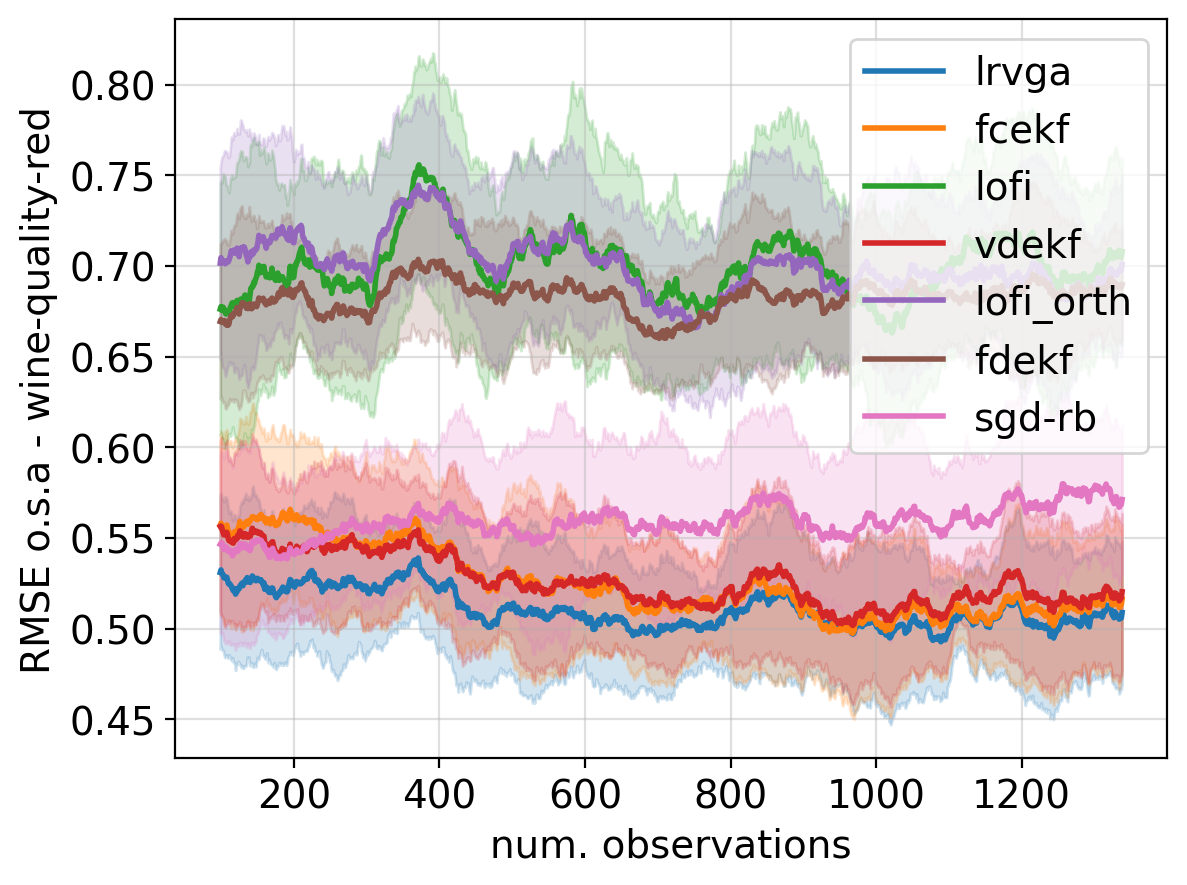

In [597]:
fig, ax = plt.subplots()
for method in methods:
    color = colors[method]
    label = f"{method}"
    test_res = pd.DataFrame(osa_collection[method].T[100:])
    plot_bounds(test_res, ax, color, label, rolling=100)
plt.legend()
plt.ylabel(f"RMSE o.s.a - {dataset_name}")
plt.xlabel("num. observations")
plt.grid(alpha=0.4)
plt.savefig(f"output/images/{dataset_name}-one-step-ahead.pdf")

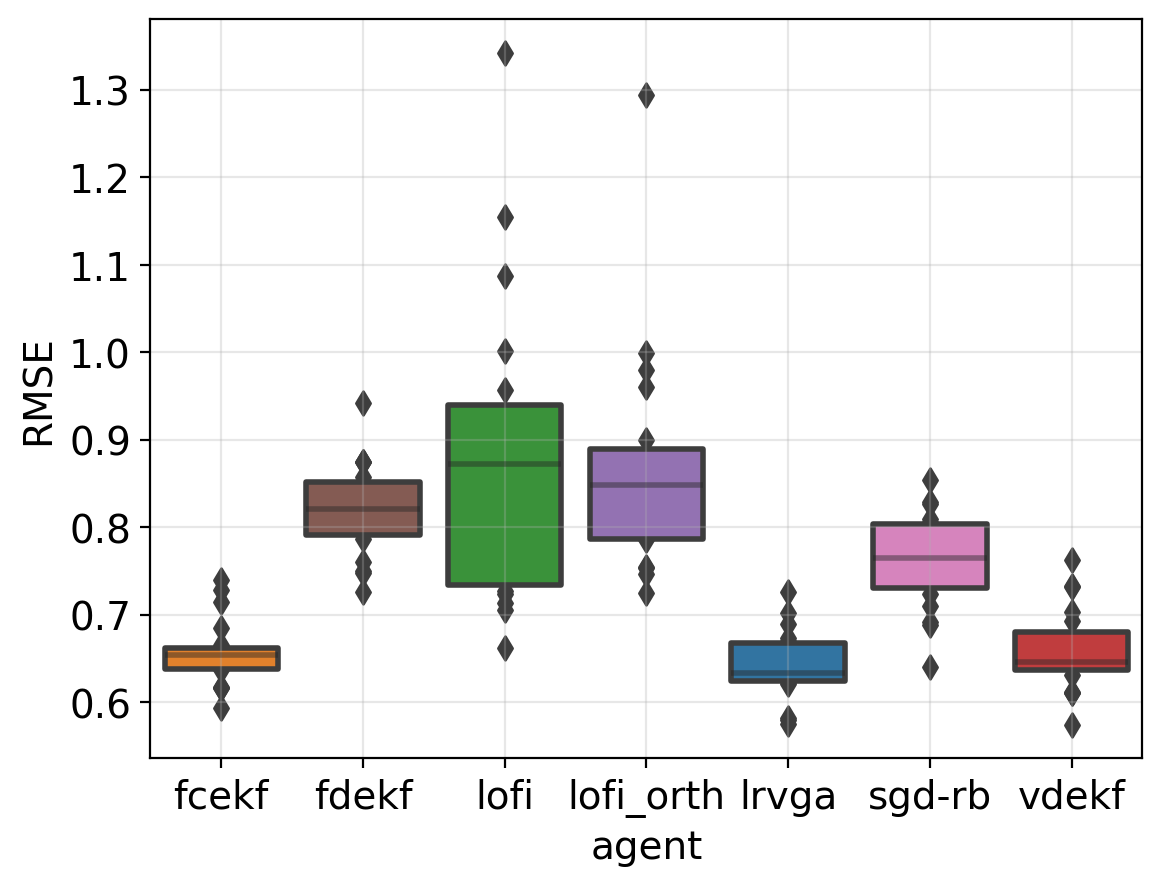

In [598]:
last_rmse = jax.tree_map(lambda x: x[:, -1], test_collection)
last_rmse = pd.DataFrame(last_rmse).melt(value_name="RMSE", var_name="agent").dropna()
sns.boxenplot(last_rmse, x="agent", y="RMSE", palette=colors)
plt.grid(alpha=0.3)
plt.savefig(f"output/images/{dataset_name}-test-set-last.pdf")

In [599]:
def format_row(row):
    mean = row["mean"]
    std = row["std"]
    label = rf"${mean:0.2f} \pm {std:0.2f}$"
    return [label]

In [600]:
last_rmse = pd.DataFrame(jax.tree_map(lambda x: x[:, -1], test_collection))
last_rmse = last_rmse.agg(["mean", "std"]).apply(format_row)
last_rmse.index = [dataset_name]
print(last_rmse.style.to_latex())

\begin{tabular}{llllllll}
 & fcekf & fdekf & lofi & lofi_orth & lrvga & sgd-rb & vdekf \\
wine-quality-red & $0.66 \pm 0.04$ & $0.82 \pm 0.05$ & $0.88 \pm 0.17$ & $0.87 \pm 0.13$ & $0.64 \pm 0.04$ & $0.76 \pm 0.05$ & $0.66 \pm 0.05$ \\
\end{tabular}

